# Rasterizing vectors & vectorizing rasters <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls_wo_fq_cyear_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_wo_fq_cyear_3)

## Background

Many remote sensing and/or geospatial workflows require converting between vector data (e.g. shapefiles) and raster data (e.g. pixel-based data like that in an `xarray.DataArray`).
For example, we may need to use a shapefile as a mask to limit the analysis extent of a raster, or have raster data that we want to convert into vector data to allow for easy geometry operations.

## Description
This notebook demonstrates the use of the DEA function `xr_rasterize` and `xr_vectorize` from [dea_tools.spatial](../Tools/dea_tools/spatial.py). 

The first section loads in [DEA Water Observations Statistics](https://cmi.ga.gov.au/data-products/dea/686/dea-water-observations-statistics-landsat) data from Digital Earth Australia, and vectorises the pixel-based `xarray.DataArray` object into a vector-based `geopandas.GeoDataFrame` object containing persistent water-bodies as polygons. 
We then export the `GeoDataframe` as a vector file.  

The second section rasterises the vector data we created in the first section back into an `xarray.DataArray`, and exports the results as a GeoTIFF.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import datacube

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.spatial import xr_vectorize, xr_rasterize


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Rasterize_vectorize')

## Load WOfS data from the datacube

We will load in an annual summary from the [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product to provide us with some data to work with. The query below will load the 2000 annual summary of WOfS for the region around the Menindee Lakes.

In [3]:
# Create a query object
query = {
    'x': (142.1, 142.80),
    'y': (-32.1, -32.6),
    'time': ('2000')
}

# Load WoFS through the datacube
ds = dc.load(product='ga_ls_wo_fq_cyear_3', 
             **query)
ds


<xarray.Dataset>
Dimensions:      (time: 1, y: 2037, x: 2324)
Coordinates:
  * time         (time) datetime64[ns] 2000-07-01T23:59:59.999999
  * y            (y) float64 -3.536e+06 -3.536e+06 ... -3.597e+06 -3.597e+06
  * x            (x) float64 9.396e+05 9.396e+05 ... 1.009e+06 1.009e+06
    spatial_ref  int32 3577
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 29 29 29 29 29 29 29 ... 14 14 14 14 14 14
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot the WOfS summary

Let's plot the WOfS data to get an idea of the objects we will be transforming. 
In the code below, we first select the pixels where the satellite has observed water at least 25% of the year, this is so we can isolate the more persistent water bodies and reduce some of the noise before we vectorize the raster.

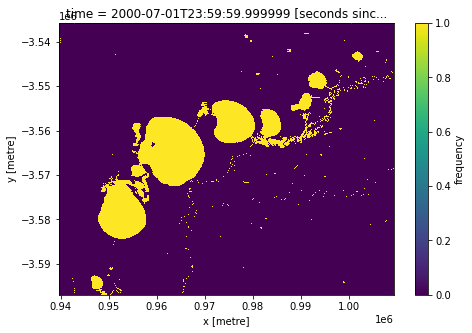

In [4]:
# Select pixels that are classified as water > 25 % of the time
water_bodies = ds.frequency > 0.25

# Plot the data
water_bodies.plot(size=5)

## Vectorizing an `xarray.DataArray`

To convert our xarray.DataArray object into a vector based `geopandas.GeoDataFrame`, we can use the DEA function `xr_vectorize` from [dea_tools.spatial](../Tools/dea_tools/spatial.py). 
This tool is based on the [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) function, and can accept any of the arguments in `rasterio.features.shape` using the same syntax.

In the cell below, we use the argument `mask=water_bodies.values==1` to indicate we only want to convert the values in the xarray object that are equal to 1.

In [10]:
from dea_tools.spatial import xr_vectorize2

gdf = xr_vectorize2(water_bodies,
                   mask=water_bodies.values==1,
                   export_shp='test.geojson')



/home/jovyan/Robbi/dea-notebooks/Frequently_used_code/../Tools/dea_tools/spatial.py:120: FutureWarning: The `export_shp` parameter is deprecated and will be removed from future versions of this function; use `output_path` instead.
  "The `export_shp` parameter is deprecated; use "


In [ ]:
water_bodies.geobox

In [ ]:
import xarray as xr
testing = xr.DataArray(water_bodies.drop('time').data)

In [ ]:
testing.odc.transform

In [ ]:
da = xr_vectorize2(testing, crs='EPSG:3577')
da.plot()

In [ ]:
import rasterio.features

dtype='float32'

vectors = rasterio.features.shapes(source=da.data.astype(dtype),
                                   transform=da.odc.transform)

In [ ]:
vectors

### Plot our vectorised raster 

In [ ]:
gdf.plot(figsize=(6, 6))

### Export as vector file

Our function also allows us to very easily export the `GeoDataFrame` as a vector file for use in other applications using the `export_shp` parameter.
For this example we will export our data as a `GeoJSON` vector file; use the extension `.shp` to export an ESRI Shapefile instead.

In [ ]:
gdf = xr_vectorize(da=water_bodies,
                   crs=ds.crs,
                   mask=water_bodies.values == 1.,
                   export_shp='test.geojson')


***
## Rasterizing a vector file

Using the `xr_rasterize` function from [dea_tools.spatial](../Tools/dea_tools/spatial.py) (based on the rasterio function: [rasterio.features.rasterize](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html), and can accept any of the arguments in `rasterio.features.rasterize` using the same syntax) we can turn the `geopandas.GeoDataFrame` back into a `xarray.Dataset`. 

As we already have the `GeoDataFrame` loaded we don't need to read in our vector file, but if we wanted to read in a vector file first we can use [gpd.read_file()](http://geopandas.org/reference/geopandas.read_file.html).   

This function uses an `xarray.datarray` object as a template for converting our GeoDataFrame into a raster object (the template provides the size, crs, dimensions, and attributes of the output array).

In [ ]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  crs=ds.crs)

water_bodies_again

We can plot out rasterised data to verify it looks identical to the `water_bodies` data we previously plotted:

In [ ]:
water_bodies_again.plot(size=5)

### Export as GeoTIFF

`xr_rasterize` also allows for exporting the results as a GeoTIFF.  To do this, a named array is required. If a name is not provided using the `name` parameter, the function will provide a default name.

In [ ]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  crs=ds.crs,
                                  export_tiff='test.tif')


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2022

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)